# Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import numpy as np
sns.set(rc={'figure.figsize':(8,4)})
from sklearn.impute import SimpleImputer
%pip install pycountry_convert -q
import pycountry_convert as pc
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import RobustScaler
from scipy import stats
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


# Read and Understand data

In [2]:
df = pd.read_csv('../input/online-df/OnlineRetail.csv', encoding= 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


- InvoiceNo, StockCode are object
- there are missing values

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


- (Quantity and UnitPrice) have negative values !! and outliers

In [5]:
df['InvoiceNo'].value_counts()[:10]

573585    1114
581219     749
581492     731
580729     721
558475     705
579777     687
581217     676
537434     675
580730     662
538071     652
Name: InvoiceNo, dtype: int64

In [6]:
df['StockCode'].value_counts()[:10]

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
84879     1502
22720     1477
22197     1476
21212     1385
20727     1350
Name: StockCode, dtype: int64

In [7]:
df['Description'].value_counts()[:10]

WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
ASSORTED COLOUR BIRD ORNAMENT         1501
SET OF 3 CAKE TINS PANTRY DESIGN      1473
PACK OF 72 RETROSPOT CAKE CASES       1385
LUNCH BAG  BLACK SKULL.               1350
NATURAL SLATE HEART CHALKBOARD        1280
Name: Description, dtype: int64

In [8]:
df['Quantity'].value_counts()[:10]

1     148227
2      81829
12     61063
6      40868
4      38484
3      37121
24     24021
10     22288
8      13129
5      11757
Name: Quantity, dtype: int64

In [9]:
df['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [10]:
# put right name of the country
df.replace('Israel', 'Palestine', inplace=True)

In [11]:
# drop useless features
df.drop(axis=1, columns=['InvoiceNo', 'StockCode', 'CustomerID'], inplace=True)

# Preprocessing

### Missing values

In [12]:
df.isnull().sum()

Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
Country           0
dtype: int64

In [13]:
# drop null values in description
df.dropna(axis=0, subset=['Description'], inplace=True)

### Convert negative values

In [14]:
df['UnitPrice'] = abs(df['UnitPrice'])

In [15]:
df[df['UnitPrice'] < 0]

,Description,Quantity,InvoiceDate,UnitPrice,Country


In [16]:
df['Quantity'] = abs(df['Quantity'])

In [17]:
df[df['Quantity'] < 0]

,Description,Quantity,InvoiceDate,UnitPrice,Country


### Outliers

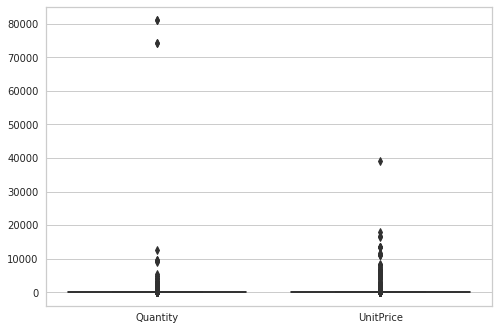

In [18]:
attributes = ['Quantity','UnitPrice']
sns.boxplot(data = df[attributes]);

In [19]:
def get_outliers(df, col):
    Q1, Q3 = np.percentile(df[col], [0.0, 85])
    intr_qr = Q3-Q1
    max = Q3+(1.5*intr_qr)
    min = Q1-(1.5*intr_qr)
    df.loc[df[col] < min, col] = np.nan
    df.loc[df[col] > max, col] = np.nan
    return df

In [20]:
df = get_outliers(df, 'Quantity')

In [21]:
df = get_outliers(df, 'UnitPrice')

In [22]:
df.isnull().sum()

Description        0
Quantity       27875
InvoiceDate        0
UnitPrice      11614
Country            0
dtype: int64

## fillna

In [23]:
imputer = SimpleImputer(strategy='mean')
df[['Quantity', 'UnitPrice']] = imputer.fit_transform(df[['Quantity', 'UnitPrice']])

In [24]:
df.head()

,Description,Quantity,InvoiceDate,UnitPrice,Country
0,WHITE HANGING HEART T-LIGHT HOLDER,6.0,01-12-2010 08:26,2.55,United Kingdom
1,WHITE METAL LANTERN,6.0,01-12-2010 08:26,3.39,United Kingdom
2,CREAM CUPID HEARTS COAT HANGER,8.0,01-12-2010 08:26,2.75,United Kingdom
3,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,01-12-2010 08:26,3.39,United Kingdom
4,RED WOOLLY HOTTIE WHITE HEART.,6.0,01-12-2010 08:26,3.39,United Kingdom


### Date

##### check if all rows in same format

In [25]:
set([len(i.split() )for i in df['InvoiceDate'].unique()])

{2}

In [26]:
set([len(j.split('-')) for j in [i.split()[0] for i in df['InvoiceDate'].unique()]])

{3}

In [27]:
set([len(j.split(':')) for j in [i.split()[1] for i in df['InvoiceDate'].unique()]])

{2}

# Feature Extraction

In [28]:
# convert date to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [29]:
# extract year, month and day from date
df['year'] = df['InvoiceDate'].dt.year
df['month'] = df['InvoiceDate'].dt.month
df['day'] = df['InvoiceDate'].dt.day
df['weekday'] = df['InvoiceDate'].dt.day_name()
df['hour'] = df['InvoiceDate'].dt.hour
df.drop(axis=1, columns='InvoiceDate', inplace=True)

In [30]:
df.head()

,Description,Quantity,UnitPrice,Country,year,month,day,weekday,hour
0,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2.55,United Kingdom,2010,1,12,Tuesday,8
1,WHITE METAL LANTERN,6.0,3.39,United Kingdom,2010,1,12,Tuesday,8
2,CREAM CUPID HEARTS COAT HANGER,8.0,2.75,United Kingdom,2010,1,12,Tuesday,8
3,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,3.39,United Kingdom,2010,1,12,Tuesday,8
4,RED WOOLLY HOTTIE WHITE HEART.,6.0,3.39,United Kingdom,2010,1,12,Tuesday,8


In [31]:
df['year'].unique()

array([2010, 2011])

In [32]:
df['weekday'].value_counts()

Thursday     96042
Tuesday      95230
Monday       86072
Friday       79892
Wednesday    78102
Sunday       71014
Saturday     34103
Name: weekday, dtype: int64

## Get Day part (morning, afternoon, evening, night)

In [33]:
def DayPart(H) :
    if H < 11 : 
        return 'Morning'
    elif 11 <= H< 16 : 
        return 'Afternoon'
    elif 16 <= H< 22 : 
        return 'Evening'
    else : 
        return 'Night'

In [34]:
df['dayPart'] = df['hour'].apply(DayPart)

In [35]:
df['dayPart'].value_counts()

Afternoon    352728
Evening       95238
Morning       92489
Name: dayPart, dtype: int64

In [36]:
# extract amount using quantity and unit price
df['Amount'] = df['Quantity'] * df['UnitPrice']
df['Amount'].describe()

count    540455.000000
mean         12.040009
std          14.686723
min           0.000000
25%           3.300000
50%           8.260000
75%          15.900000
max         362.600000
Name: Amount, dtype: float64

# Dealing with Text 

### Put all rows in one paragrph

In [37]:
df['Description'].tolist()[:10]

['WHITE HANGING HEART T-LIGHT HOLDER',
 'WHITE METAL LANTERN',
 'CREAM CUPID HEARTS COAT HANGER',
 'KNITTED UNION FLAG HOT WATER BOTTLE',
 'RED WOOLLY HOTTIE WHITE HEART.',
 'SET 7 BABUSHKA NESTING BOXES',
 'GLASS STAR FROSTED T-LIGHT HOLDER',
 'HAND WARMER UNION JACK',
 'HAND WARMER RED POLKA DOT',
 'ASSORTED COLOUR BIRD ORNAMENT']

In [38]:
AllDescription = ' '.join(df['Description'].tolist())
AllDescription = ' '.join([(i).lower() 
                           for i in AllDescription.split()])

In [39]:
len(AllDescription.split())

2368906

In [40]:
AllDescription[:1000]

"white hanging heart t-light holder white metal lantern cream cupid hearts coat hanger knitted union flag hot water bottle red woolly hottie white heart. set 7 babushka nesting boxes glass star frosted t-light holder hand warmer union jack hand warmer red polka dot assorted colour bird ornament poppy's playhouse bedroom poppy's playhouse kitchen feltcraft princess charlotte doll ivory knitted mug cosy box of 6 assorted colour teaspoons box of vintage jigsaw blocks box of vintage alphabet blocks home building block word love building block word recipe box with metal heart doormat new england jam making set with jars red coat rack paris fashion yellow coat rack paris fashion blue coat rack paris fashion bath building block word alarm clock bakelike pink alarm clock bakelike red alarm clock bakelike green panda and bunnies sticker sheet stars gift tape inflatable political globe vintage heads and tails card game set/2 red retrospot tea towels round snack boxes set of4 woodland spaceboy lu

### Remove stop words

In [41]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [42]:
stop_words = set(stopwords.words('english'))

In [43]:
all_words = AllDescription.split()
all_words[:5]

['white', 'hanging', 'heart', 't-light', 'holder']

In [44]:
len(all_words)

2368906

In [45]:
words = []

In [46]:
for w in all_words:
    if w not in stop_words and len(w) > 1:
        words.append(w)

In [47]:
MostRepeatedWords = {}

for Word in words : 
    if Word in MostRepeatedWords.keys() : 
        MostRepeatedWords[Word] +=1
    else : 
        MostRepeatedWords[Word] =1
MostRepeatedWords

{'white': 20813,
 'hanging': 17037,
 'heart': 38714,
 't-light': 14559,
 'holder': 16261,
 'metal': 20842,
 'lantern': 2371,
 'cream': 8045,
 'cupid': 340,
 'hearts': 5023,
 'coat': 1634,
 'hanger': 2201,
 'knitted': 794,
 'union': 5465,
 'flag': 1774,
 'hot': 10517,
 'water': 9978,
 'bottle': 11697,
 'red': 42902,
 'woolly': 450,
 'hottie': 449,
 'heart.': 449,
 'set': 54598,
 'babushka': 3211,
 'nesting': 508,
 'boxes': 3254,
 'glass': 12125,
 'star': 6107,
 'frosted': 164,
 'hand': 4944,
 'warmer': 4622,
 'jack': 3816,
 'polka': 199,
 'dot': 109,
 'assorted': 7587,
 'colour': 6207,
 'bird': 5871,
 'ornament': 1501,
 "poppy's": 1455,
 'playhouse': 1455,
 'bedroom': 436,
 'kitchen': 3608,
 'feltcraft': 7216,
 'princess': 1192,
 'charlotte': 6351,
 'doll': 2244,
 'ivory': 8205,
 'mug': 8234,
 'cosy': 1307,
 'box': 24406,
 'teaspoons': 213,
 'vintage': 33748,
 'jigsaw': 1676,
 'blocks': 515,
 'alphabet': 3921,
 'home': 9545,
 'building': 1747,
 'block': 2281,
 'word': 1747,
 'love': 800

In [48]:
# see unique words
len(MostRepeatedWords.keys())

2463

In [49]:
MostRepeatedWords=  {k:v for k,v in sorted(
    MostRepeatedWords.items(),key = lambda
    item: item[1],reverse = True) }
MostRepeatedWords

{'set': 54598,
 'bag': 51911,
 'red': 42902,
 'heart': 38714,
 'retrospot': 35126,
 'vintage': 33748,
 'design': 30066,
 'pink': 29526,
 'christmas': 25131,
 'box': 24406,
 'cake': 21461,
 'jumbo': 21139,
 'metal': 20842,
 'white': 20813,
 'blue': 19319,
 'lunch': 18525,
 'hanging': 17037,
 'sign': 16998,
 'holder': 16261,
 'pack': 15637,
 't-light': 14559,
 'paper': 14365,
 'small': 14333,
 'card': 13280,
 'decoration': 12981,
 'wooden': 12708,
 'polkadot': 12472,
 'glass': 12125,
 'cases': 12014,
 'tea': 11836,
 'bottle': 11697,
 '12': 11401,
 'spaceboy': 10831,
 'hot': 10517,
 'water': 9978,
 'large': 9798,
 'pantry': 9760,
 'home': 9545,
 'tin': 9512,
 'rose': 9402,
 'paisley': 9326,
 'ceramic': 9180,
 'regency': 9120,
 'green': 9119,
 'dolly': 8447,
 'doormat': 8385,
 'mug': 8234,
 'ivory': 8205,
 'mini': 8185,
 'cream': 8045,
 'bunting': 8001,
 'love': 8000,
 'girl': 7793,
 'assorted': 7587,
 'party': 7559,
 'clock': 7381,
 'feltcraft': 7216,
 'black': 7205,
 'wicker': 7141,
 'bo

In [50]:
# see the first ten words
most_wprds = list(MostRepeatedWords.keys())[:15]
most_wprds

['set',
 'bag',
 'red',
 'heart',
 'retrospot',
 'vintage',
 'design',
 'pink',
 'christmas',
 'box',
 'cake',
 'jumbo',
 'metal',
 'white',
 'blue']

In [51]:
# get important word
important_word = most_wprds[1:]

In [52]:
for Word in important_word : 
    df[f'Repeated Word : {Word}'] = df['Description'].apply(lambda x : 1 if Word in x.lower() else 0)

In [53]:
df.head()

,Description,Quantity,UnitPrice,Country,year,month,day,weekday,hour,dayPart,...,Repeated Word : vintage,Repeated Word : design,Repeated Word : pink,Repeated Word : christmas,Repeated Word : box,Repeated Word : cake,Repeated Word : jumbo,Repeated Word : metal,Repeated Word : white,Repeated Word : blue
0,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2.55,United Kingdom,2010,1,12,Tuesday,8,Morning,...,0,0,0,0,0,0,0,0,1,0
1,WHITE METAL LANTERN,6.0,3.39,United Kingdom,2010,1,12,Tuesday,8,Morning,...,0,0,0,0,0,0,0,1,1,0
2,CREAM CUPID HEARTS COAT HANGER,8.0,2.75,United Kingdom,2010,1,12,Tuesday,8,Morning,...,0,0,0,0,0,0,0,0,0,0
3,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,3.39,United Kingdom,2010,1,12,Tuesday,8,Morning,...,0,0,0,0,0,0,0,0,0,0
4,RED WOOLLY HOTTIE WHITE HEART.,6.0,3.39,United Kingdom,2010,1,12,Tuesday,8,Morning,...,0,0,0,0,0,0,0,0,1,0


In [54]:
df[df['Repeated Word : red']==1]['Description'][:10]

4      RED WOOLLY HOTTIE WHITE HEART.
8           HAND WARMER RED POLKA DOT
22        RED COAT RACK PARIS FASHION
27          ALARM CLOCK BAKELIKE RED 
33    SET/2 RED RETROSPOT TEA TOWELS 
39      RED TOADSTOOL LED NIGHT LIGHT
47          HAND WARMER RED POLKA DOT
52              EDWARDIAN PARASOL RED
62     RED WOOLLY HOTTIE WHITE HEART.
69              EDWARDIAN PARASOL RED
Name: Description, dtype: object

## From country get continent

In [55]:
def fromCountryToContinent(x):
    if x == 'EIRE' or x == 'Channel Islands' or x=='European Community':
        return 'Europe'
    elif x == 'RSA':
        return 'Africa'
    elif x =='Unspecified':
        return 'Unspecified'
    else:
        country_code = pc.country_name_to_country_alpha2(x, cn_name_format="default")
        return pc.country_alpha2_to_continent_code(country_code)

In [56]:
df['continent'] = df['Country'].apply(fromCountryToContinent)

In [57]:
df.head()

,Description,Quantity,UnitPrice,Country,year,month,day,weekday,hour,dayPart,...,Repeated Word : design,Repeated Word : pink,Repeated Word : christmas,Repeated Word : box,Repeated Word : cake,Repeated Word : jumbo,Repeated Word : metal,Repeated Word : white,Repeated Word : blue,continent
0,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2.55,United Kingdom,2010,1,12,Tuesday,8,Morning,...,0,0,0,0,0,0,0,1,0,EU
1,WHITE METAL LANTERN,6.0,3.39,United Kingdom,2010,1,12,Tuesday,8,Morning,...,0,0,0,0,0,0,1,1,0,EU
2,CREAM CUPID HEARTS COAT HANGER,8.0,2.75,United Kingdom,2010,1,12,Tuesday,8,Morning,...,0,0,0,0,0,0,0,0,0,EU
3,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,3.39,United Kingdom,2010,1,12,Tuesday,8,Morning,...,0,0,0,0,0,0,0,0,0,EU
4,RED WOOLLY HOTTIE WHITE HEART.,6.0,3.39,United Kingdom,2010,1,12,Tuesday,8,Morning,...,0,0,0,0,0,0,0,1,0,EU


# Data Visualization

In [58]:
def CPlot(data,feature) : 
    fig, ax = plt.subplots(figsize=(10,6))
    sns.countplot(x=feature, data=data,facecolor=(0, 0, 0, 0),
                  linewidth=5,edgecolor=sns.color_palette("dark", 3))
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

def KPlot(data,feature,Limit=0) : 
    fig, ax = plt.subplots(figsize=(10,6))
    if Limit == 0 : 
        sns.kdeplot(data[feature], shade=True)
    else : 
        Data = data[data[feature]<=Limit]
        sns.kdeplot(Data[feature], shade=True)
def BPlot(data,feature1,feature2 = None,hue = None) : 
    fig, ax = plt.subplots(figsize=(10,6))
    if feature2 ==  None and hue == None : 
        sns.boxplot(data[feature1],width=0.3,color='r')
    elif  feature2 !=  None and hue == None :
        sns.boxplot(x = data[feature1],y=data[feature2],width=0.3,color='r')
    elif  feature2 !=  None and hue != None :
        sns.boxplot(x = data[feature1],y=data[feature2],hue=data[hue],width=0.3,color='r')
        
def JPlot(data,feature1,feature2,Type = 'scatter') : 
    sns.jointplot(data=data, x=feature1, y=feature2, kind=Type)   
    
    
def Pie(data,feature,Limit=20) : 
    fig, ax = plt.subplots(figsize=(10,6))
    plt.pie(data[feature].value_counts()[:Limit],labels=list(
        data[feature].value_counts()[:Limit].index),
        autopct ='%1.2f%%' , labeldistance = 1.1,
            explode = [0.05 for i in range(len(data[feature].value_counts()[:Limit]))] )
    plt.show()     

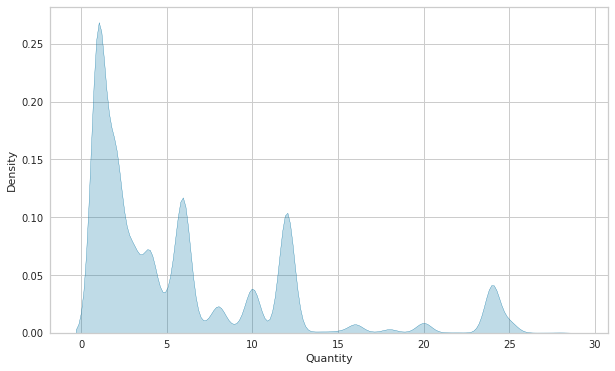

In [59]:
KPlot(df,'Quantity')

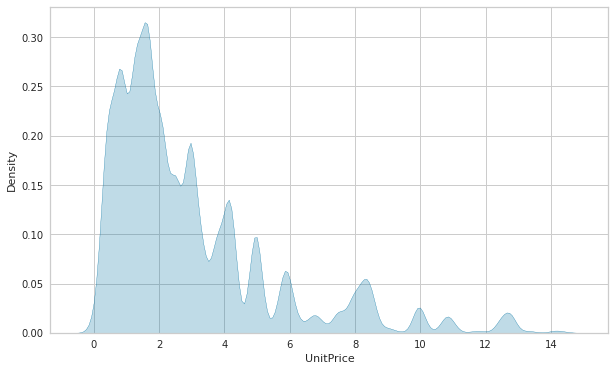

In [60]:
KPlot(df,'UnitPrice')

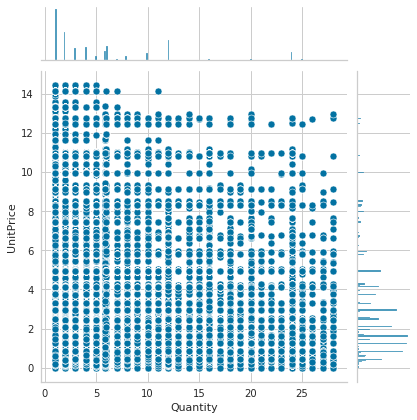

In [61]:
JPlot(df ,'Quantity','UnitPrice')

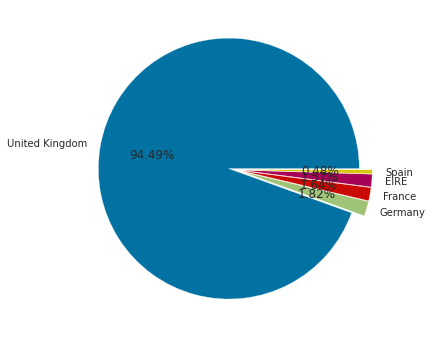

In [62]:
Pie(df,'Country',5)

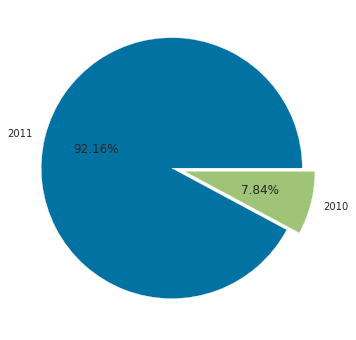

In [63]:
Pie(df,'year')

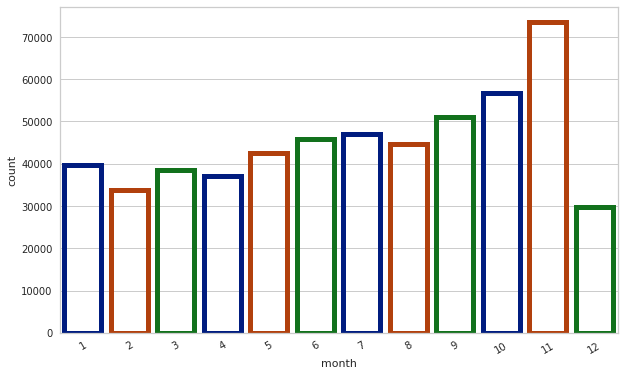

In [64]:
CPlot(df,'month')

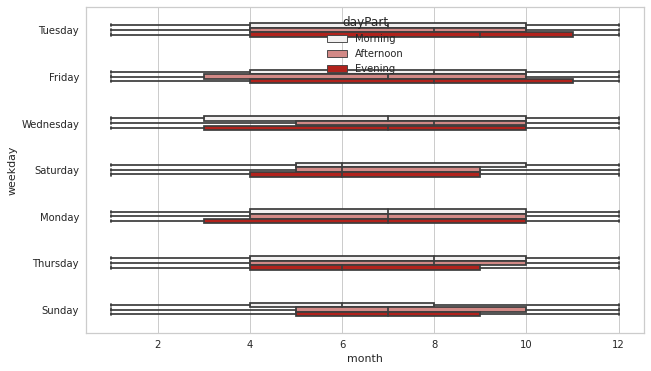

In [65]:
BPlot(df,'month','weekday','dayPart')

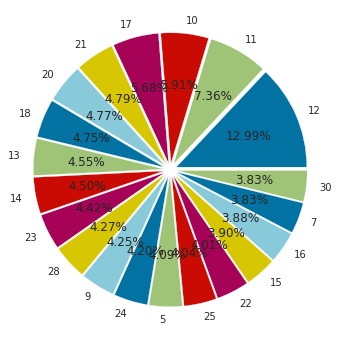

In [66]:
Pie(df,'day')

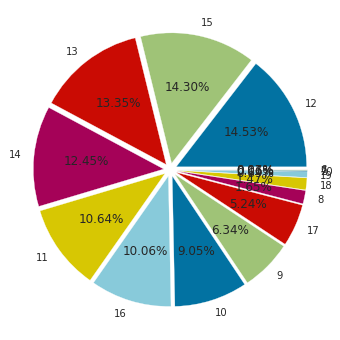

In [67]:
Pie(df,'hour')

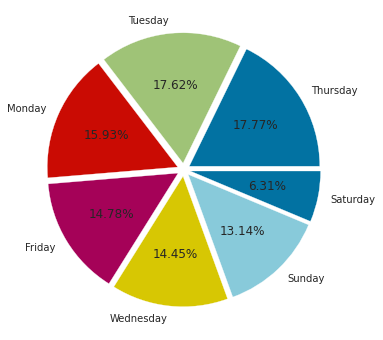

In [68]:
Pie(df,'weekday')

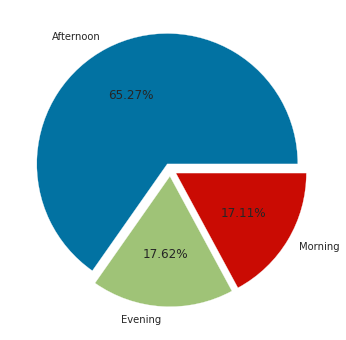

In [69]:
Pie(df,'dayPart')

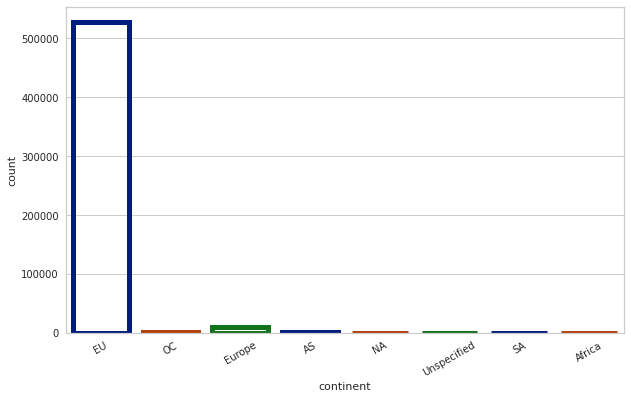

In [70]:
CPlot(df,'continent')

# Data Preparing

In [71]:
df.columns

Index(['Description', 'Quantity', 'UnitPrice', 'Country', 'year', 'month',
       'day', 'weekday', 'hour', 'dayPart', 'Amount', 'Repeated Word : bag',
       'Repeated Word : red', 'Repeated Word : heart',
       'Repeated Word : retrospot', 'Repeated Word : vintage',
       'Repeated Word : design', 'Repeated Word : pink',
       'Repeated Word : christmas', 'Repeated Word : box',
       'Repeated Word : cake', 'Repeated Word : jumbo',
       'Repeated Word : metal', 'Repeated Word : white',
       'Repeated Word : blue', 'continent'],
      dtype='object')

In [72]:
df_model = df[['Description', 'Quantity', 'UnitPrice', 'Country']]

## Label encoding

In [73]:
encoder = BinaryEncoder()
encoder_df = encoder.fit_transform(df_model[['Description', 'Country']])
df_model[encoder_df.columns] = encoder_df

In [74]:
df_model.drop(['Description', 'Country'], axis=1, inplace=True)

## Scale

In [75]:
scaler = RobustScaler()

df_model[df_model.columns] = scaler.fit_transform(df_model[df_model.columns])

In [76]:
df_model.head()

,Quantity,UnitPrice,Description_0,Description_1,Description_2,Description_3,Description_4,Description_5,Description_6,Description_7,...,Description_9,Description_10,Description_11,Description_12,Country_0,Country_1,Country_2,Country_3,Country_4,Country_5
0,0.428571,0.174074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.428571,0.485185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.714286,0.248148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.428571,0.485185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.428571,0.485185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model

## Silhouette Analysis

In [77]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_model)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df_model, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.16257149716877228
For n_clusters=3, the silhouette score is 0.15534806898003495
For n_clusters=4, the silhouette score is 0.0974544662776157
For n_clusters=5, the silhouette score is 0.0916874575954364
For n_clusters=6, the silhouette score is 0.08629426874942994
For n_clusters=7, the silhouette score is 0.07542899012207921
For n_clusters=8, the silhouette score is 0.06922230633794905


In [78]:
# final model with k=3
kmeans = KMeans(n_clusters=2, max_iter=50)
kmeans.fit(df_model)

KMeans(max_iter=50, n_clusters=2)

In [79]:
# assign the label
df_model['class'] = kmeans.labels_
df_model.head()

,Quantity,UnitPrice,Description_0,Description_1,Description_2,Description_3,Description_4,Description_5,Description_6,Description_7,...,Description_10,Description_11,Description_12,Country_0,Country_1,Country_2,Country_3,Country_4,Country_5,class
0,0.428571,0.174074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.428571,0.485185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.714286,0.248148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.428571,0.485185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.428571,0.485185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


<AxesSubplot:xlabel='class', ylabel='Quantity'>

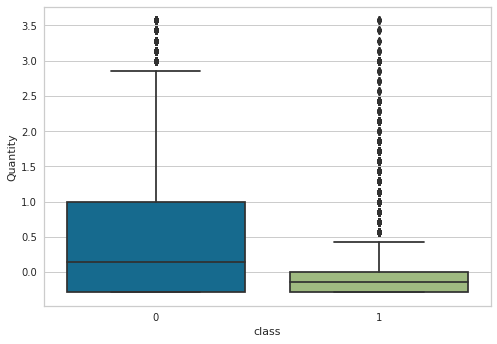

In [80]:
# plots
sns.boxplot(x='class', y='Quantity', data=df_model)

<AxesSubplot:xlabel='class', ylabel='UnitPrice'>

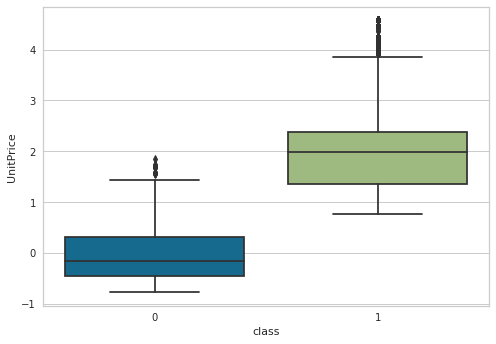

In [81]:
# plots
sns.boxplot(x='class', y='UnitPrice', data=df_model)